In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
image = cv2.imread( r"stock-photo-ancient-egyptian-hieroglyphs-seamless-282723371.jpg")

# Step 2: Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 3: Create a binary mask using thresholding
# Adjust the threshold value (e.g., 127) based on your image
_, binary_mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Step 4: Save the binary image
cv2.imwrite("binary_image.png", binary_mask)

True

In [11]:
def connected_components_with_stats(binary_image):
    height, width = binary_image.shape
    labels = np.zeros((height, width), dtype=np.int32)
    label = 1
    equivalences = {}

    # First pass
    for y in range(height):
        for x in range(width):
            if binary_image[y, x] == 255:
                neighbors = []

                if x > 0 and labels[y, x-1] > 0:
                    neighbors.append(labels[y, x-1])
                if y > 0 and labels[y-1, x] > 0:
                    neighbors.append(labels[y-1, x])
                if x > 0 and y > 0 and labels[y-1, x-1] > 0:
                    neighbors.append(labels[y-1, x-1])
                if x < width-1 and y > 0 and labels[y-1, x+1] > 0:
                    neighbors.append(labels[y-1, x+1])

                if not neighbors:
                    labels[y, x] = label
                    equivalences[label] = {label}
                    label += 1
                else:
                    min_label = min(neighbors)
                    labels[y, x] = min_label
                    for n in neighbors:
                        equivalences[min_label].update(
                            equivalences.get(n, {n})
                        )
                        for l in equivalences.get(n, {n}):
                            equivalences[l] = equivalences[min_label]

    # Flatten equivalences
    label_map = {}
    new_label = 1
    for y in range(height):
        for x in range(width):
            old_label = labels[y, x]
            if old_label > 0:
                root = min(equivalences[old_label])
                if root not in label_map:
                    label_map[root] = new_label
                    new_label += 1
                labels[y, x] = label_map[root]

    num_labels = new_label - 1

    # Stats
    stats = np.zeros((num_labels + 1, 5), dtype=np.int32)
    for lbl in range(1, num_labels + 1):
        ys, xs = np.where(labels == lbl)
        if len(xs) > 0:
            x = np.min(xs)
            y = np.min(ys)
            w = np.max(xs) - np.min(xs) + 1
            h = np.max(ys) - np.min(ys) + 1
            area = len(xs)
            stats[lbl] = [x, y, w, h, area]

    centroids = np.zeros((num_labels + 1, 2), dtype=np.float32)
    for lbl in range(1, num_labels + 1):
        ys, xs = np.where(labels == lbl)
        if len(xs) > 0:
            centroids[lbl] = [np.mean(xs), np.mean(ys)]

    return num_labels, labels, stats, centroids


In [12]:
num_labels, labels, stats, centroids = connected_components_with_stats(binary_mask)

print("Total components detected:", num_labels)


Total components detected: 908


In [13]:
output_folder = "hiro_alphabet1"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print("Output folder ready.")


Output folder ready.


In [14]:
for i in range(1, num_labels):  # skip background
    x, y, w, h, area = stats[i]
    if area > 50:  # noise filter
        component = binary_mask[y:y+h, x:x+w]
        cv2.imwrite(
            os.path.join(output_folder, f"alphabet_{i}.png"),
            component
        )

print("Alphabets extracted and saved.")


Alphabets extracted and saved.


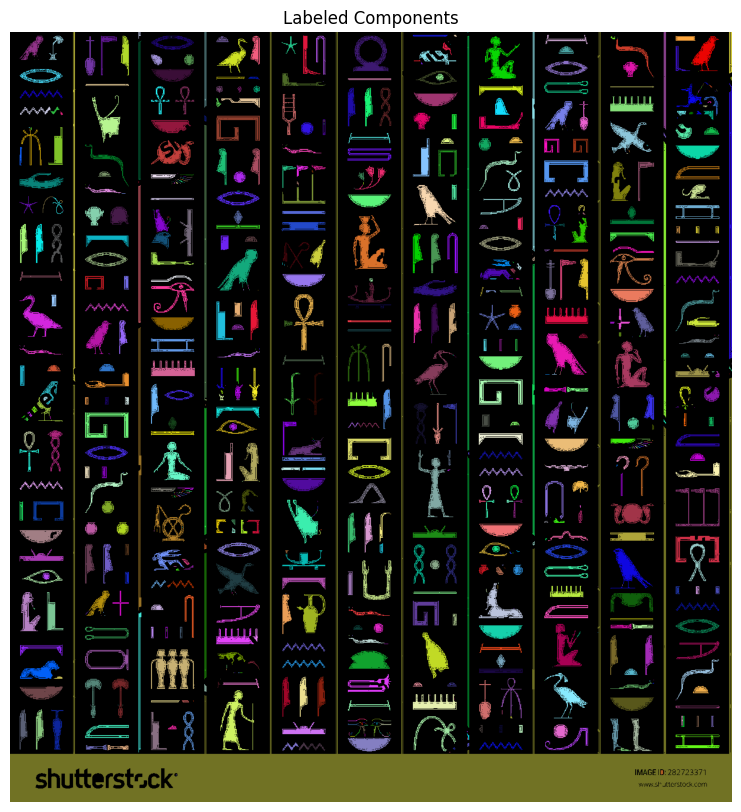

In [15]:
output = np.zeros(
    (binary_mask.shape[0], binary_mask.shape[1], 3),
    dtype=np.uint8
)

for i in range(1, num_labels):
    mask = labels == i
    output[mask] = np.random.randint(0, 255, 3)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Labeled Components")
plt.axis("off")
plt.show()


In [16]:
print(f"Number of alphabets/components detected: {num_labels - 1}")


Number of alphabets/components detected: 907
